##Import

In [3]:
import pandas as pd
import numpy as np
import os
import torch
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv('/content/weatherAUS.csv')
df_t = df.copy(deep=True) 

##Preparação dos dados

Na preparação dos dados excluimos algumas colunas que possuem muitos dados nulos que poderiam atrapalhar a nossa analise.

In [5]:
df_t = df_t.drop(columns=['Cloud3pm','Cloud9am','Sunshine','Rainfall','Evaporation']) # Colunas com muitos NULOS
df_t = df_t.dropna() #Exclusão das colunas

In [6]:
tempmin = df_t['MinTemp'].min() #Dados Necessarios para Normalização da Coluna 
tempmax = df_t['MaxTemp'].min()
windgus = df_t['WindGustSpeed'].min()
windgus9 = df_t['WindSpeed9am'].min()
windgus3 = df_t['WindSpeed3pm'].min()
humidity9 = df_t['Humidity9am'].min()
humidity3 = df_t['Humidity3pm'].min()
pressure9 = df_t['Pressure9am'].min()
pressure3 = df_t['Pressure3pm'].min()
temp9 = df_t['Temp9am'].min() 
temp3 = df_t['Temp3pm'].min()


tempminm = df_t['MinTemp'].max() #Dados Necessarios para Normalização da Coluna
tempmaxm = df_t['MaxTemp'].max()
windgusm = df_t['WindGustSpeed'].max()
windgus9m = df_t['WindSpeed9am'].max()
windgus3m = df_t['WindSpeed3pm'].max()
humidity9m = df_t['Humidity9am'].max()
humidity3m = df_t['Humidity3pm'].max()
pressure9m = df_t['Pressure9am'].max()
pressure3m = df_t['Pressure3pm'].max()
temp9m = df_t['Temp9am'].max()
temp3m = df_t['Temp3pm'].max()

In [7]:
minimo = {
    "Temperatura Minima" : tempmin,
    "Temperatura Maxima" : tempmax,
    "Rajadas de Vento" : windgus,
    "Rajadas de Vento as 9am" : windgus9,
    "Rajadas de Vento as 3pm" : windgus3,
    "Humidade as 9am" : humidity9,
    "Humidade as 3pm" : humidity3,
    "Pressão as 9am": pressure9,
    "Pressão as 3pm": pressure3,
    "Temperatura as 9am": temp9,
    "Temperatura as 3pm": temp3
}

maximo = {
    "Temperatura Minima" : tempminm,
    "Temperatura Maxima" : tempmaxm,
    "Rajadas de Vento" : windgusm,
    "Rajadas de Vento as 9am" : windgus9m,
    "Rajadas de Vento as 3pm" : windgus3m,
    "Humidade as 9am" : humidity9m,
    "Humidade as 3pm" : humidity3m,
    "Pressão as 9am": pressure9m,
    "Pressão as 3pm": pressure3m,
    "Temperatura as 9am": temp9m,
    "Temperatura as 3pm": temp3m
}

In [8]:
df_t['MinTemp'] = df_t['MinTemp'].apply(lambda x: ((x-(-8.2))/(33.9-(-8.2))))
df_t['MaxTemp'] = df_t['MaxTemp'].apply(lambda x: ((x-2.6)/(48.1-2.6)))
df_t['WindGustSpeed'] = df_t['WindGustSpeed'].apply(lambda x: ((x-7.0)/(135.0-7.0)))
df_t['WindSpeed9am'] = df_t['WindSpeed9am'].apply(lambda x: ((x-2.0)/(87.0-2.0)))
df_t['WindSpeed3pm'] = df_t['WindSpeed3pm'].apply( lambda x: ((x-2.0)/(87.0-2.0)))
df_t['Humidity9am'] = df_t['Humidity9am'].apply( lambda x:((x-0.0)/(100.0-0.0)))
df_t['Humidity3pm'] = df_t['Humidity3pm'].apply( lambda x:((x-0.0)/(100.0-0.0)))
df_t['Pressure9am'] = df_t['Pressure9am'].apply(lambda x: ((x-980.5)/(1041.0 - 980.5)))
df_t['Pressure3pm'] = df_t['Pressure3pm'].apply(lambda x: ((x-977.1)/(1039.6 - 977.1)))
df_t['Temp9am'] = df_t['Temp9am'].apply(lambda x: ((x-(-3.1)))/(40.2 -(-3.1)))
df_t['Temp3pm'] = df_t['Temp3pm'].apply(lambda x: ((x-1.7))/(46.7 - 1.7))

In [9]:
df_t['Chove_Amanha'] = [1 if x == 'Yes' else 0 for x in df_t['RainTomorrow']]

In [10]:
df_t['Direcao_Vento'] = df_t['WindGustDir'].str[:1]
df_t['Direcao_Vento9am'] = df_t['WindDir9am'].str[:1]
df_t['Direcao_Vento3pm'] = df_t['WindDir3pm'].str[:1]

In [11]:
df_t = pd.get_dummies(df_t, columns=["Direcao_Vento"])
df_t = pd.get_dummies(df_t, columns=["Direcao_Vento9am"])
df_t = pd.get_dummies(df_t, columns=["Direcao_Vento3pm"])

In [12]:
colunas_s_alvo = df_t.columns[3:]
colunas_s_alvo = colunas_s_alvo.drop(["WindGustDir","WindDir9am","WindDir3pm","RainTomorrow","RainToday","Chove_Amanha"])

##Separação em Treinamento, Validação e Testes

In [13]:
X = df_t[colunas_s_alvo]
X = X.to_numpy()


y = df_t['Chove_Amanha'].to_numpy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,
    stratify = y,
    random_state = 88
)

In [15]:
X_train.shape, X_test.shape, X.shape

((40121, 22), (17196, 22), (57317, 22))

##Modelando utilizando PyTorch

In [16]:
TAXA_APRENDIZADO = 0.01
BATCH = 64
EPOCAS = 100

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # linearizar a matriz de entrada
        self.flatten = nn.Flatten()
        # Sequencia de tarefas da rede
        self.linear_relu_stack = nn.Sequential(            
            nn.Linear(2*2, 7), # primiera camada - aplicar transformação de linear. 2*2 características e 7 neurônios          
            nn.ReLU(),  # ativar saída - transformar entre 0 e x            
            nn.Linear(7, 5), # segunda camada - aplicar transformação de linear. 5 neurônios
            nn.ReLU(), # ativar saída - transformar entre 0 e x
            nn.Linear(5, 2),  # terceira camada - aplicar transformação de linear. 2 neurônios (2 categorias)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class MLP(nn.Module):
    def __init__(self, n_attrs):
        super(MLP, self).__init__()

        # Sequencia de tarefas da rede
        self.mlp_stack = nn.Sequential(            
            nn.Linear(n_attrs, 7), # primiera camada - aplicar transformação de linear. n características e 7 neurônios          
            nn.ReLU(),  # ativar saída - transformar entre 0 e x            
            nn.Linear(7, 5), # segunda camada - aplicar transformação de linear. 5 neurônios
            nn.ReLU(), # ativar saída - transformar entre 0 e x
            nn.Linear(5, 1),  # terceira camada - aplicar transformação de linear. 2 neurônios (2 categorias)
            nn.Sigmoid() # ativação da rede - Sigmoid - saída entre 0 e 1
        )

    def forward(self, x):
        y = self.mlp_stack(x)
        return y

In [18]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [20]:
# inicialização do modelo
model = MLP(n_attrs=len(X[0]))
model.to(device)

MLP(
  (mlp_stack): Sequential(
    (0): Linear(in_features=22, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [21]:
dataset = CustomDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())

In [22]:
contador=Counter(y)

pesos_classes=1./np.array([contador[0],contador[1]])

pesos_amostra = np.array([pesos_classes[int(t)] for t in y])
pesos_amostra=torch.from_numpy(pesos_amostra)
amostra = WeightedRandomSampler(pesos_amostra, len(pesos_amostra))

In [23]:
dataset_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH,
    sampler=amostra
)

In [24]:
custo_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=TAXA_APRENDIZADO)

In [25]:
valores_custo = []
valores_acuracia = []

for t in range(EPOCAS):
  custo_epoca = 0
  acuracia_epoca = 0

  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(dataset_loader.dataset) # quantidade de registros

  #configurar modelo para treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_batch, y_batch) in enumerate(dataset_loader):

    # usar GPU
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    # fazer predição com modelo
    y_pred = model(X_batch)

    # calcular erro    
    custo = custo_fn(y_pred, y_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca +=  custo.item()

    # acuracia
    # y_pred tem uma saída para cada categoria (2 neurônios). 
    # torch.max() retorna o índice do maior valor
    # 0: catgoria 0
    # 1: categoria 1
    #_, y_pred_tags = torch.max(y_pred, dim = 1)
    acuracia_epoca += accuracy_score(y_batch.cpu(), torch.round(y_pred).detach().cpu()) # .cpu() remove o uso da GPU
  
  valores_custo.append(custo_epoca/len(dataset_loader))
  valores_acuracia.append(acuracia_epoca/len(dataset_loader))
  print(f"custo: {valores_custo[-1]:>5.4f}\t|\tacurácia: {valores_acuracia[-1]:>5.4f}")


-------------------------------
Época 1
custo: 0.6921	|	acurácia: 0.5295

-------------------------------
Época 2
custo: 0.6877	|	acurácia: 0.6040

-------------------------------
Época 3
custo: 0.6783	|	acurácia: 0.6467

-------------------------------
Época 4
custo: 0.6503	|	acurácia: 0.6869

-------------------------------
Época 5
custo: 0.5819	|	acurácia: 0.7289

-------------------------------
Época 6
custo: 0.5250	|	acurácia: 0.7476

-------------------------------
Época 7
custo: 0.5010	|	acurácia: 0.7551

-------------------------------
Época 8
custo: 0.4959	|	acurácia: 0.7580

-------------------------------
Época 9
custo: 0.4911	|	acurácia: 0.7612

-------------------------------
Época 10
custo: 0.4919	|	acurácia: 0.7580

-------------------------------
Época 11
custo: 0.4922	|	acurácia: 0.7572

-------------------------------
Época 12
custo: 0.4845	|	acurácia: 0.7643

-------------------------------
Época 13
custo: 0.4865	|	acurácia: 0.7622

-------------------------------
É

##Avaliação do Desempenho 01

In [26]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=88)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=88)

In [27]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [28]:
contador=Counter(y_train)

pesos_classes=1./np.array([contador[0],contador[1]])

pesos_amostra = np.array([pesos_classes[int(t)] for t in y_train])
pesos_amostra=torch.from_numpy(pesos_amostra)
amostra = WeightedRandomSampler(pesos_amostra, len(pesos_amostra))

In [29]:
train_loader = DataLoader(dataset=train_dataset,  batch_size=BATCH, sampler=amostra)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# inicialização do modelo
model = MLP(n_attrs=len(X[0]))
model.to(device)

custo_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=TAXA_APRENDIZADO)

Using cpu device


In [31]:
valores_custo = {
    "treinamento": [],
    "validacao": []
}

valores_acuracia = {
    "treinamento": [],
    "validacao": []
}

for t in range(EPOCAS):
  
  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(train_loader.dataset) # quantidade de registros

  custo_epoca_train = 0
  acuracia_epoca_train = 0
  # treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_train_batch, y_train_batch) in enumerate(train_loader):
    
    # usar GPU
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

    # fazer predição com modelo
    y_train_pred = model(X_train_batch)

    # calcular erro    
    custo = custo_fn(y_train_pred, y_train_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca_train +=  custo.item()

    # acuracia
    #_, y_pred_tags_train = torch.max(y_train_pred, dim = 1)
    acuracia_epoca_train += accuracy_score(y_train_batch.cpu(), torch.round(y_train_pred).detach().cpu())
  
  # validacao

  with torch.no_grad():
        
    custo_epoca_val = 0
    acuracia_epoca_val = 0

    # configural modelo para validacao
    model.eval()
    for X_val_batch, y_val_batch in val_loader:     

      # usar GPU
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

      y_val_pred = model(X_val_batch)
                  
      custo_val = custo_fn(y_val_pred, y_val_batch.unsqueeze(1))
      
      custo_epoca_val += custo_val.item()

      # acuracia
      #_, y_pred_tags_val = torch.max(y_val_pred, dim = 1)
      acuracia_epoca_val += accuracy_score(y_val_batch.cpu(), torch.round(y_val_pred).detach().cpu())
  
  valores_custo['treinamento'].append(custo_epoca_train/len(train_loader))
  valores_custo['validacao'].append(custo_epoca_val/len(val_loader))

  valores_acuracia['treinamento'].append(acuracia_epoca_train/len(train_loader))
  valores_acuracia['validacao'].append(acuracia_epoca_val/len(val_loader))
  print('Treinamento')
  print(f"custo: {valores_custo['treinamento'][-1]:>5.4f}\t|\tacurácia: {valores_acuracia['treinamento'][-1]:>5.4f}")
  print('Validação')
  print(f"custo: {valores_custo['validacao'][-1]:>5.4f}\t|\tacurácia: {valores_acuracia['validacao'][-1]:>5.4f}")
  


-------------------------------
Época 1
Treinamento
custo: 0.6932	|	acurácia: 0.5123
Validação
custo: 0.6938	|	acurácia: 0.4869

-------------------------------
Época 2
Treinamento
custo: 0.6922	|	acurácia: 0.5307
Validação
custo: 0.6969	|	acurácia: 0.3297

-------------------------------
Época 3
Treinamento
custo: 0.6914	|	acurácia: 0.5538
Validação
custo: 0.6954	|	acurácia: 0.4315

-------------------------------
Época 4
Treinamento
custo: 0.6901	|	acurácia: 0.5930
Validação
custo: 0.6933	|	acurácia: 0.5196

-------------------------------
Época 5
Treinamento
custo: 0.6878	|	acurácia: 0.6232
Validação
custo: 0.6805	|	acurácia: 0.6986

-------------------------------
Época 6
Treinamento
custo: 0.6839	|	acurácia: 0.6381
Validação
custo: 0.6753	|	acurácia: 0.7163

-------------------------------
Época 7
Treinamento
custo: 0.6760	|	acurácia: 0.6727
Validação
custo: 0.6665	|	acurácia: 0.7167

-------------------------------
Época 8
Treinamento
custo: 0.6600	|	acurácia: 0.7166
Validação
c

In [32]:
y_pred = []
with torch.no_grad():
  model.eval()
  for X_batch, _ in test_loader:
    X_batch = X_batch.to(device)
    y_test_pred = model(X_batch)
    #_, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred.append(torch.round(y_test_pred).cpu().numpy())
y_pred = [a.squeeze().tolist() for a in y_pred]

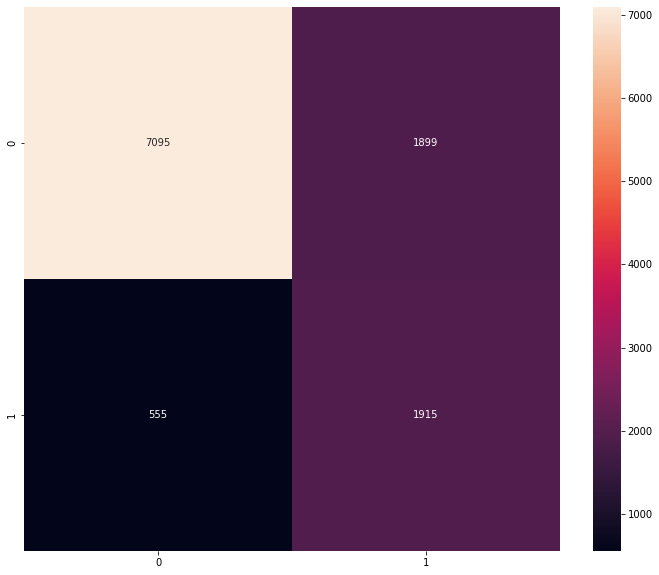

In [33]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred)) #Avaliação de Desempenho 01

plt.subplots(figsize=(12,10))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [34]:
resultado_1 = classification_report(y_test,y_pred)

##Simulações com diferentes valores para os hiperparâmetros

(taxa de aprendizado, épocas, camadas intermediárias, neurônios nas camadas intermediárias)

In [35]:
TAXA_APRENDIZADO = 0.03 #Aumento da Taxa de Aprendizado
BATCH = 64
EPOCAS = 119 #Aumento das Epocas

In [36]:
dataset_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH,
    sampler=amostra
)

In [37]:
valores_custov2 = []
valores_acuraciav2 = []

for t in range(EPOCAS):
  custo_epoca = 0
  acuracia_epoca = 0

  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(dataset_loader.dataset) # quantidade de registros

  #configurar modelo para treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_batch, y_batch) in enumerate(dataset_loader):

    # usar GPU
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    # fazer predição com modelo
    y_pred = model(X_batch)

    # calcular erro    
    custo = custo_fn(y_pred, y_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca +=  custo.item()

    # acuracia
    # y_pred tem uma saída para cada categoria (2 neurônios). 
    # torch.max() retorna o índice do maior valor
    # 0: catgoria 0
    # 1: categoria 1
    #_, y_pred_tags = torch.max(y_pred, dim = 1)
    acuracia_epoca += accuracy_score(y_batch.cpu(), torch.round(y_pred).detach().cpu()) # .cpu() remove o uso da GPU
  
  valores_custov2.append(custo_epoca/len(dataset_loader))
  valores_acuraciav2.append(acuracia_epoca/len(dataset_loader))
  print(f"custo: {valores_custov2[-1]:>5.4f}\t|\tacurácia: {valores_acuraciav2[-1]:>5.4f}")


-------------------------------
Época 1
custo: 0.3687	|	acurácia: 0.8392

-------------------------------
Época 2
custo: 0.3672	|	acurácia: 0.8405

-------------------------------
Época 3
custo: 0.3624	|	acurácia: 0.8440

-------------------------------
Época 4
custo: 0.3647	|	acurácia: 0.8420

-------------------------------
Época 5
custo: 0.3644	|	acurácia: 0.8420

-------------------------------
Época 6
custo: 0.3626	|	acurácia: 0.8417

-------------------------------
Época 7
custo: 0.3634	|	acurácia: 0.8429

-------------------------------
Época 8
custo: 0.3616	|	acurácia: 0.8451

-------------------------------
Época 9
custo: 0.3644	|	acurácia: 0.8425

-------------------------------
Época 10
custo: 0.3669	|	acurácia: 0.8407

-------------------------------
Época 11
custo: 0.3610	|	acurácia: 0.8455

-------------------------------
Época 12
custo: 0.3716	|	acurácia: 0.8389

-------------------------------
Época 13
custo: 0.3703	|	acurácia: 0.8395

-------------------------------
É

##Avaliação do Desempenho 02

In [38]:
train_loader = DataLoader(dataset=train_dataset,  batch_size=BATCH, sampler=amostra)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# inicialização do modelo
model = MLP(n_attrs=len(X[0]))
model.to(device)

custo_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=TAXA_APRENDIZADO)

Using cpu device


In [40]:
valores_custov2 = {
    "treinamento": [],
    "validacao": []
}

valores_acuraciav2 = {
    "treinamento": [],
    "validacao": []
}

for t in range(EPOCAS):
  
  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(train_loader.dataset) # quantidade de registros

  custo_epoca_train = 0
  acuracia_epoca_train = 0
  # treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_train_batch, y_train_batch) in enumerate(train_loader):
    
    # usar GPU
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

    # fazer predição com modelo
    y_train_pred = model(X_train_batch)

    # calcular erro    
    custo = custo_fn(y_train_pred, y_train_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca_train +=  custo.item()

    # acuracia
    #_, y_pred_tags_train = torch.max(y_train_pred, dim = 1)
    acuracia_epoca_train += accuracy_score(y_train_batch.cpu(), torch.round(y_train_pred).detach().cpu())
  
  # validacao

  with torch.no_grad():
        
    custo_epoca_val = 0
    acuracia_epoca_val = 0

    # configural modelo para validacao
    model.eval()
    for X_val_batch, y_val_batch in val_loader:     

      # usar GPU
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

      y_val_pred = model(X_val_batch)
                  
      custo_val = custo_fn(y_val_pred, y_val_batch.unsqueeze(1))
      
      custo_epoca_val += custo_val.item()

      # acuracia
      #_, y_pred_tags_val = torch.max(y_val_pred, dim = 1)
      acuracia_epoca_val += accuracy_score(y_val_batch.cpu(), torch.round(y_val_pred).detach().cpu())
  
  valores_custov2['treinamento'].append(custo_epoca_train/len(train_loader))
  valores_custov2['validacao'].append(custo_epoca_val/len(val_loader))

  valores_acuraciav2['treinamento'].append(acuracia_epoca_train/len(train_loader))
  valores_acuraciav2['validacao'].append(acuracia_epoca_val/len(val_loader))
  print('Treinamento')
  print(f"custo: {valores_custov2['treinamento'][-1]:>5.4f}\t|\tacurácia: {valores_acuraciav2['treinamento'][-1]:>5.4f}")
  print('Validação')
  print(f"custo: {valores_custov2['validacao'][-1]:>5.4f}\t|\tacurácia: {valores_acuraciav2['validacao'][-1]:>5.4f}")


-------------------------------
Época 1
Treinamento
custo: 0.6949	|	acurácia: 0.4820
Validação
custo: 0.6865	|	acurácia: 0.7846

-------------------------------
Época 2
Treinamento
custo: 0.6934	|	acurácia: 0.4986
Validação
custo: 0.6942	|	acurácia: 0.3666

-------------------------------
Época 3
Treinamento
custo: 0.6931	|	acurácia: 0.5023
Validação
custo: 0.6977	|	acurácia: 0.2152

-------------------------------
Época 4
Treinamento
custo: 0.6928	|	acurácia: 0.5163
Validação
custo: 0.6907	|	acurácia: 0.6417

-------------------------------
Época 5
Treinamento
custo: 0.6922	|	acurácia: 0.5340
Validação
custo: 0.6889	|	acurácia: 0.5911

-------------------------------
Época 6
Treinamento
custo: 0.6896	|	acurácia: 0.5577
Validação
custo: 0.6808	|	acurácia: 0.6446

-------------------------------
Época 7
Treinamento
custo: 0.6709	|	acurácia: 0.6393
Validação
custo: 0.6326	|	acurácia: 0.7366

-------------------------------
Época 8
Treinamento
custo: 0.5744	|	acurácia: 0.7361
Validação
c

In [41]:
y_pred2 = []
with torch.no_grad():
  model.eval()
  for X_batch, _ in test_loader:
    X_batch = X_batch.to(device)
    y_test_pred = model(X_batch)
    #_, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred2.append(torch.round(y_test_pred).cpu().numpy())
y_pred2 = [a.squeeze().tolist() for a in y_pred2]

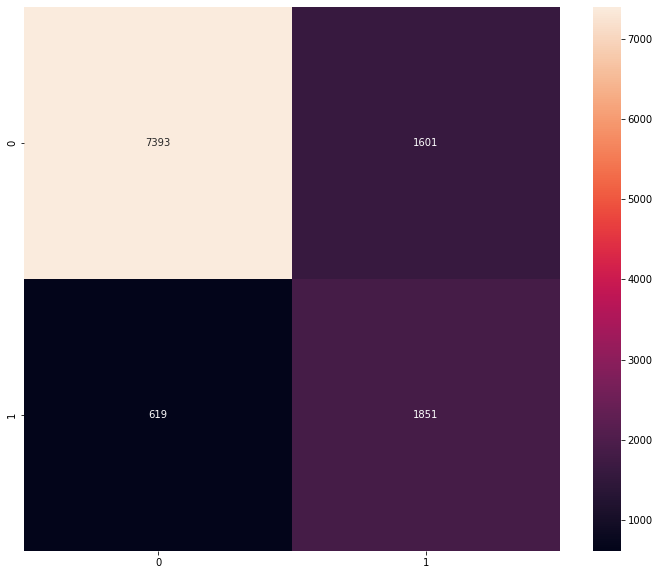

In [42]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred2)) #Avaliação de Desempenho 02

plt.subplots(figsize=(12,10))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [43]:
resultado_2 = classification_report(y_test,y_pred2)

##Nova Simulação

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # linearizar a matriz de entrada
        self.flatten = nn.Flatten()
        # Sequencia de tarefas da rede
        self.linear_relu_stack = nn.Sequential(            
            nn.Linear(2*2, 10), # primiera camada - aplicar transformação de linear. 2*2 características e 7 neurônios          
            nn.ReLU(),  # ativar saída - transformar entre 0 e x            
            nn.Linear(10, 8), # segunda camada - aplicar transformação de linear. 5 neurônios
            nn.ReLU(), # ativar saída - transformar entre 0 e x
            nn.Linear(8, 5),  # terceira camada - aplicar transformação de linear. 3 neurônios (3 categorias)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class MLP(nn.Module):
    def __init__(self, n_attrs):
        super(MLP, self).__init__()

        # Sequencia de tarefas da rede
        self.mlp_stack = nn.Sequential(            
            nn.Linear(n_attrs, 7), # primiera camada - aplicar transformação de linear. n características e 7 neurônios          
            nn.ReLU(),  # ativar saída - transformar entre 0 e x            
            nn.Linear(7, 5), # segunda camada - aplicar transformação de linear. 5 neurônios
            nn.ReLU(), # ativar saída - transformar entre 0 e x
            nn.Linear(5, 1),  # terceira camada - aplicar transformação de linear. 2 neurônios (2 categorias)
            nn.Sigmoid() # ativação da rede - Sigmoid - saída entre 0 e 1
        )

    def forward(self, x):
        y = self.mlp_stack(x)
        return y

In [45]:
TAXA_APRENDIZADO = 0.02 
BATCH = 64
EPOCAS = 75 

In [46]:
valores_custov3 = []
valores_acuraciav3 = []

for t in range(EPOCAS):
  custo_epoca = 0
  acuracia_epoca = 0

  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(dataset_loader.dataset) # quantidade de registros

  #configurar modelo para treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_batch, y_batch) in enumerate(dataset_loader):

    # usar GPU
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    # fazer predição com modelo
    y_pred = model(X_batch)

    # calcular erro    
    custo = custo_fn(y_pred, y_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca +=  custo.item()

    # acuracia
    # y_pred tem uma saída para cada categoria (2 neurônios). 
    # torch.max() retorna o índice do maior valor
    # 0: catgoria 0
    # 1: categoria 1
    #_, y_pred_tags = torch.max(y_pred, dim = 1)
    acuracia_epoca += accuracy_score(y_batch.cpu(), torch.round(y_pred).detach().cpu()) # .cpu() remove o uso da GPU
  
  valores_custov3.append(custo_epoca/len(dataset_loader))
  valores_acuraciav3.append(acuracia_epoca/len(dataset_loader))
  print(f"custo: {valores_custov3[-1]:>5.4f}\t|\tacurácia: {valores_acuraciav3[-1]:>5.4f}")


-------------------------------
Época 1
custo: 0.3663	|	acurácia: 0.8398

-------------------------------
Época 2
custo: 0.3642	|	acurácia: 0.8402

-------------------------------
Época 3
custo: 0.3602	|	acurácia: 0.8456

-------------------------------
Época 4
custo: 0.3619	|	acurácia: 0.8420

-------------------------------
Época 5
custo: 0.3598	|	acurácia: 0.8431

-------------------------------
Época 6
custo: 0.3599	|	acurácia: 0.8456

-------------------------------
Época 7
custo: 0.3615	|	acurácia: 0.8437

-------------------------------
Época 8
custo: 0.3622	|	acurácia: 0.8432

-------------------------------
Época 9
custo: 0.3646	|	acurácia: 0.8421

-------------------------------
Época 10
custo: 0.3578	|	acurácia: 0.8443

-------------------------------
Época 11
custo: 0.3546	|	acurácia: 0.8467

-------------------------------
Época 12
custo: 0.3650	|	acurácia: 0.8421

-------------------------------
Época 13
custo: 0.3587	|	acurácia: 0.8458

-------------------------------
É

##Avaliação do Desempenho 03

In [47]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=88)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=88)

In [48]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [49]:
contador=Counter(y_train)

pesos_classes=1./np.array([contador[0],contador[1]])

pesos_amostra = np.array([pesos_classes[int(t)] for t in y_train])
pesos_amostra=torch.from_numpy(pesos_amostra)
amostra = WeightedRandomSampler(pesos_amostra, len(pesos_amostra))

In [50]:
train_loader = DataLoader(dataset=train_dataset,  batch_size=BATCH, sampler=amostra)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# inicialização do modelo
model = MLP(n_attrs=len(X[0]))
model.to(device)

custo_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=TAXA_APRENDIZADO)

Using cpu device


In [52]:
valores_custov3 = {
    "treinamento": [],
    "validacao": []
}

valores_acuraciav3 = {
    "treinamento": [],
    "validacao": []
}

for t in range(EPOCAS):
  
  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(train_loader.dataset) # quantidade de registros

  custo_epoca_train = 0
  acuracia_epoca_train = 0
  # treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_train_batch, y_train_batch) in enumerate(train_loader):
    
    # usar GPU
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

    # fazer predição com modelo
    y_train_pred = model(X_train_batch)

    # calcular erro    
    custo = custo_fn(y_train_pred, y_train_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca_train +=  custo.item()

    # acuracia
    #_, y_pred_tags_train = torch.max(y_train_pred, dim = 1)
    acuracia_epoca_train += accuracy_score(y_train_batch.cpu(), torch.round(y_train_pred).detach().cpu())
  
  # validacao

  with torch.no_grad():
        
    custo_epoca_val = 0
    acuracia_epoca_val = 0

    # configural modelo para validacao
    model.eval()
    for X_val_batch, y_val_batch in val_loader:     

      # usar GPU
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

      y_val_pred = model(X_val_batch)
                  
      custo_val = custo_fn(y_val_pred, y_val_batch.unsqueeze(1))
      
      custo_epoca_val += custo_val.item()

      # acuracia
      #_, y_pred_tags_val = torch.max(y_val_pred, dim = 1)
      acuracia_epoca_val += accuracy_score(y_val_batch.cpu(), torch.round(y_val_pred).detach().cpu())
  
  valores_custov3['treinamento'].append(custo_epoca_train/len(train_loader))
  valores_custov3['validacao'].append(custo_epoca_val/len(val_loader))

  valores_acuraciav3['treinamento'].append(acuracia_epoca_train/len(train_loader))
  valores_acuraciav3['validacao'].append(acuracia_epoca_val/len(val_loader))
  print('Treinamento')
  print(f"custo: {valores_custov3['treinamento'][-1]:>5.4f}\t|\tacurácia: {valores_acuraciav3['treinamento'][-1]:>5.4f}")
  print('Validação')
  print(f"custo: {valores_custov3['validacao'][-1]:>5.4f}\t|\tacurácia: {valores_acuraciav3['validacao'][-1]:>5.4f}")
  


-------------------------------
Época 1
Treinamento
custo: 0.6929	|	acurácia: 0.5139
Validação
custo: 0.6937	|	acurácia: 0.4810

-------------------------------
Época 2
Treinamento
custo: 0.6915	|	acurácia: 0.5374
Validação
custo: 0.6887	|	acurácia: 0.5676

-------------------------------
Época 3
Treinamento
custo: 0.6878	|	acurácia: 0.5748
Validação
custo: 0.6791	|	acurácia: 0.6391

-------------------------------
Época 4
Treinamento
custo: 0.6771	|	acurácia: 0.6147
Validação
custo: 0.6465	|	acurácia: 0.7274

-------------------------------
Época 5
Treinamento
custo: 0.6335	|	acurácia: 0.6980
Validação
custo: 0.5552	|	acurácia: 0.7787

-------------------------------
Época 6
Treinamento
custo: 0.5491	|	acurácia: 0.7450
Validação
custo: 0.5057	|	acurácia: 0.7593

-------------------------------
Época 7
Treinamento
custo: 0.5086	|	acurácia: 0.7530
Validação
custo: 0.4739	|	acurácia: 0.7732

-------------------------------
Época 8
Treinamento
custo: 0.4999	|	acurácia: 0.7535
Validação
c

In [53]:
y_pred3 = []
with torch.no_grad():
  model.eval()
  for X_batch, _ in test_loader:
    X_batch = X_batch.to(device)
    y_test_pred = model(X_batch)
    #_, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred3.append(torch.round(y_test_pred).cpu().numpy())
y_pred3 = [a.squeeze().tolist() for a in y_pred3]

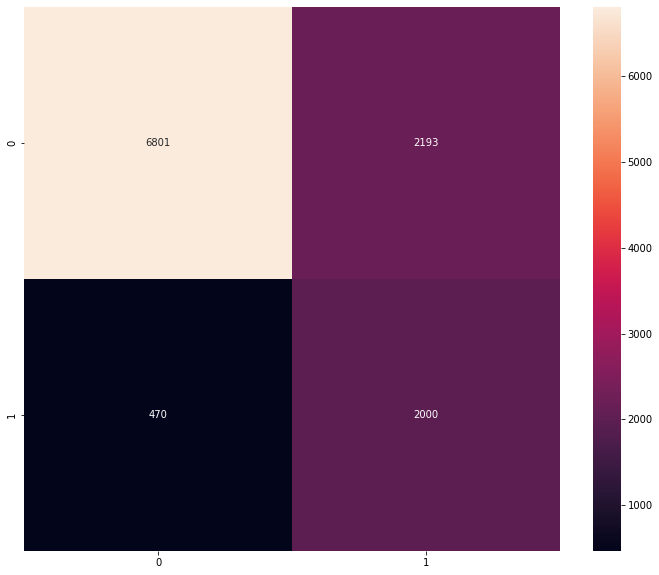

In [54]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred3)) #Avaliação de Desempenho 03

plt.subplots(figsize=(12,10))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [55]:
resultado_3 = classification_report(y_test,y_pred3)

##Gráficos que mostram mostrando as diferenças entre eles

Text(0.5, 1.0, 'Acurácia treinamento/Época')

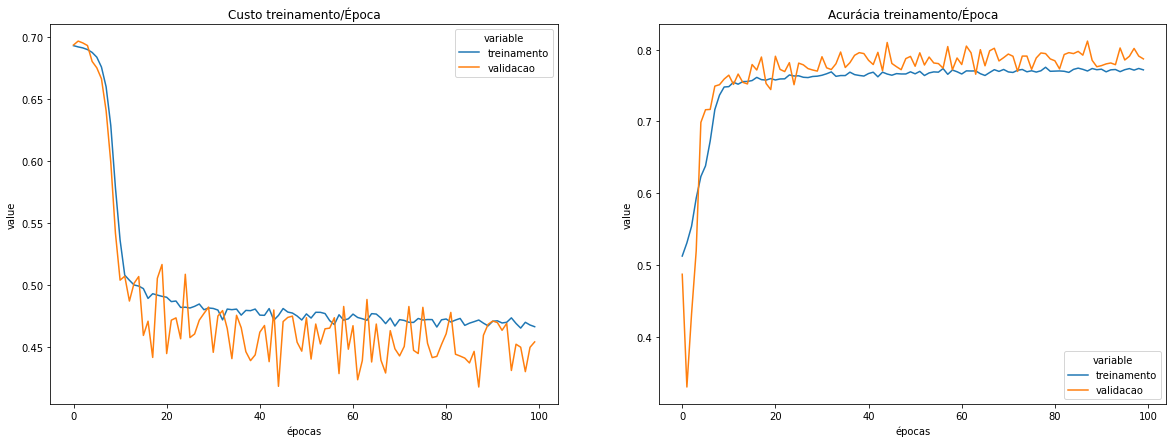

In [56]:
custo_df = pd.DataFrame.from_dict(valores_custo).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})
acuracia_df = pd.DataFrame.from_dict(valores_acuracia).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=custo_df, x = "épocas", y="value", hue="variable", ax=axes[0]).set_title('Custo treinamento/Época')
sns.lineplot(data=acuracia_df, x = "épocas", y="value", hue="variable", ax=axes[1]).set_title('Acurácia treinamento/Época')

Text(0.5, 1.0, 'Acurácia treinamento/Época v2')

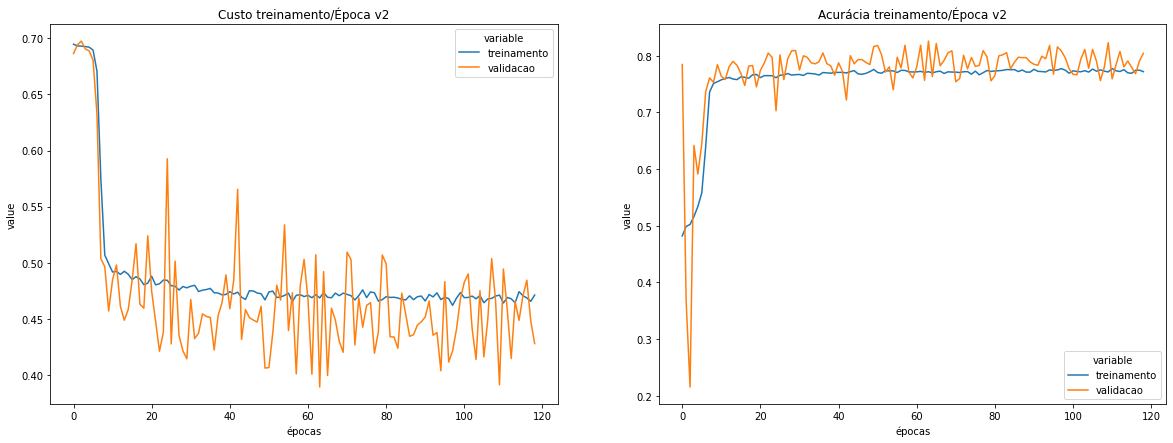

In [57]:
custo_df2 = pd.DataFrame.from_dict(valores_custov2).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})
acuracia_df2 = pd.DataFrame.from_dict(valores_acuraciav2).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=custo_df2, x = "épocas", y="value", hue="variable", ax=axes[0]).set_title('Custo treinamento/Época v2')
sns.lineplot(data=acuracia_df2, x = "épocas", y="value", hue="variable", ax=axes[1]).set_title('Acurácia treinamento/Época v2')

Text(0.5, 1.0, 'Acurácia treinamento/Época v3')

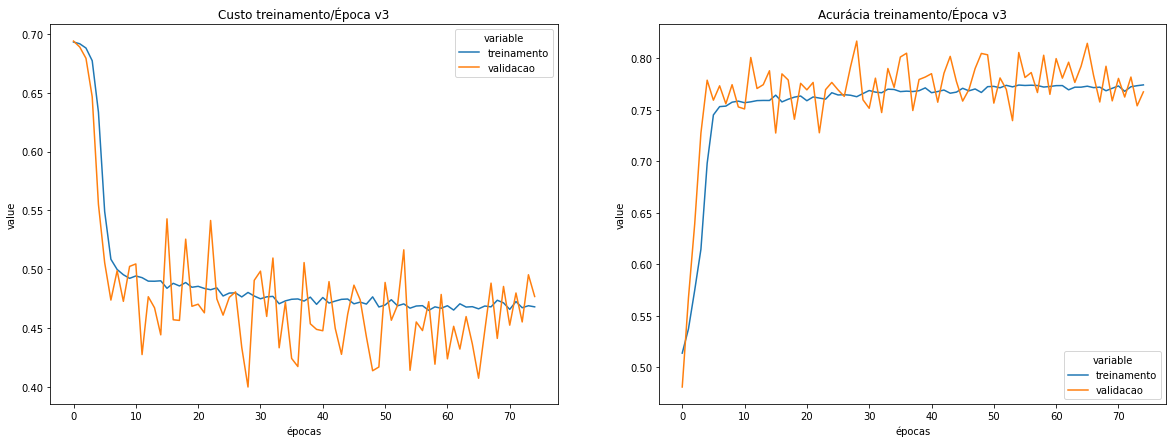

In [58]:
custo_df3 = pd.DataFrame.from_dict(valores_custov3).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})
acuracia_df3 = pd.DataFrame.from_dict(valores_acuraciav3).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=custo_df3, x = "épocas", y="value", hue="variable", ax=axes[0]).set_title('Custo treinamento/Época v3')
sns.lineplot(data=acuracia_df3, x = "épocas", y="value", hue="variable", ax=axes[1]).set_title('Acurácia treinamento/Época v3')

##A melhor combinação de hiperparâmetros

In [59]:
print(resultado_1) #melhor hiperparametros

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      8994
           1       0.50      0.78      0.61      2470

    accuracy                           0.79     11464
   macro avg       0.71      0.78      0.73     11464
weighted avg       0.84      0.79      0.80     11464



In [60]:
print(resultado_2)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      8994
           1       0.54      0.75      0.63      2470

    accuracy                           0.81     11464
   macro avg       0.73      0.79      0.75     11464
weighted avg       0.84      0.81      0.82     11464



In [61]:
print(resultado_3)

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      8994
           1       0.48      0.81      0.60      2470

    accuracy                           0.77     11464
   macro avg       0.71      0.78      0.72     11464
weighted avg       0.84      0.77      0.79     11464

